# Literature Review

# Implementation

In [1]:
import torch
import torch.nn as tnn
import torchvision as tvision
import torch.optim as toptim

import matplotlib.pyplot as plt

In [2]:
# Setup a config parameter for automaticaly choosing between CPU/GPU compute depending on whether a NVIDIA CUDA capable GPU is present
COMPUTE_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.device(COMPUTE_DEVICE)

device(type='cuda')

In [3]:
# Setup dataset parameters and training hyperparameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 1000
MEAN = 0.5
STD_DEV = 0.5
EPOCHS = 10
BASE_LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.1
LEARNING_RATE_STEP_SIZE = 1

In [4]:
# Calculate the mean and std dev from the dataset
train_set = tvision.datasets.EMNIST(root="./dataset", train=True, split="byclass", transform=tvision.transforms.ToTensor(), download=True)

flattened_data = torch.stack([img for img, _ in train_set])

MEAN = flattened_data.view(1, -1).mean(dim=1).item()
STD_DEV = flattened_data.view(1, -1).std(dim=1).item()

print(f"MEAN: {MEAN}")
print(f"STD_DEV: {STD_DEV}")

MEAN: 0.1735922247171402
STD_DEV: 0.3316516578197479


In [5]:
train_transforms = tvision.transforms.Compose(
    [
        tvision.transforms.ToTensor(),
        tvision.transforms.RandomRotation(90),
        tvision.transforms.Normalize(MEAN, STD_DEV)
    ]
)

eval_transforms = tvision.transforms.Compose(
    [
        tvision.transforms.ToTensor(),
        tvision.transforms.Normalize(MEAN, STD_DEV)
    ]
)

In [6]:
# Load the dataset
training_set = tvision.datasets.EMNIST(root="./dataset", train=True, split="byclass", transform=train_transforms, download=True)
evaluation_set = tvision.datasets.EMNIST(root="./dataset", train=False, split="byclass", transform=eval_transforms, download=True)

training_set_loader = torch.utils.data.DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
evaluation_set_loader = torch.utils.data.DataLoader(evaluation_set, batch_size=EVAL_BATCH_SIZE, shuffle=False)

label_character_map = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

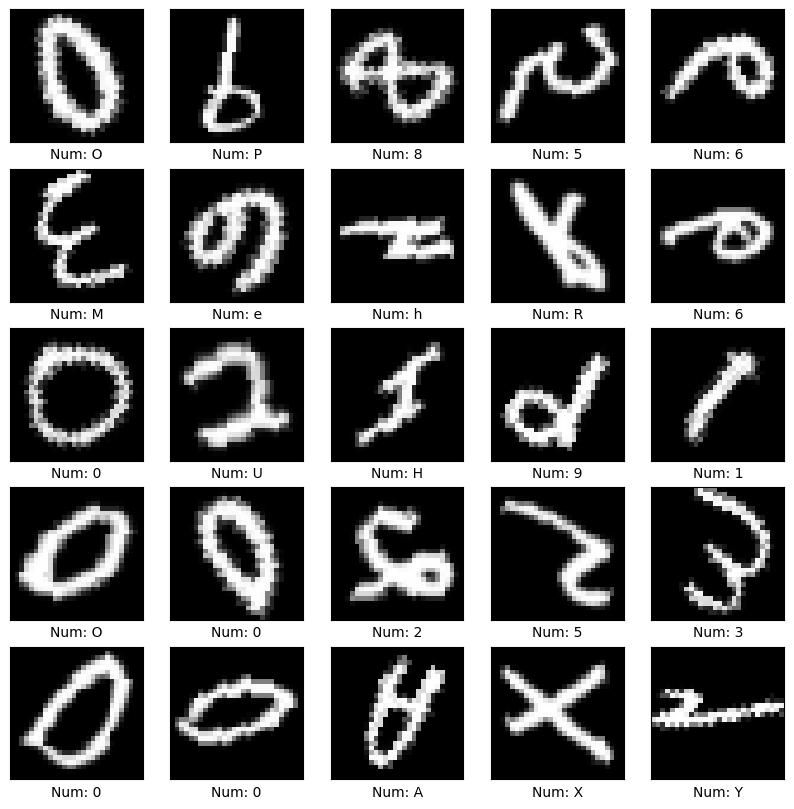

In [7]:
# Get a copy of the data loader so that it can be iterated without affecting the model
train_set_imgs, train_set_labels = next(iter(training_set_loader))

# Display a single training batch

plt.figure(figsize=(10, 10))

for i in range(25):
    img = train_set_imgs[i]
    lbl = train_set_labels[i]

    plt.subplot(5, 5, i + 1)
    plt.xlabel(f"Num: {label_character_map[lbl]}")
    plt.imshow(img.numpy().squeeze(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

plt.show()

In [8]:
# Setup the model layers
model = tnn.Sequential(
    tnn.Conv2d(1, 32, 3, 1, 1),
    tnn.BatchNorm2d(32),
    tnn.ReLU(),
    tnn.MaxPool2d(2, 2),

    tnn.Conv2d(32, 64, 3, 1, 1),
    tnn.BatchNorm2d(64),
    tnn.ReLU(),
    tnn.MaxPool2d(2, 2),

    tnn.Flatten(),
    tnn.Linear(64 * 7 * 7, 128), # img is 7x7 after going through two 2x2 pooling layers, multiplied then by the number of feature layers
    tnn.ReLU(),
    tnn.Dropout(0.2),
    tnn.Linear(128, len(label_character_map)) # The output layer count matches the number of output classes, 62 for full EMNIST
).to(COMPUTE_DEVICE)

In [9]:
# Setup optimizer, loss and learning rate scheduler functions
loss_func = tnn.CrossEntropyLoss()
optimizer = toptim.Adam(model.parameters(), lr=BASE_LEARNING_RATE)
lr_sched = toptim.lr_scheduler.StepLR(optimizer=optimizer, gamma=LEARNING_RATE_GAMMA, step_size=LEARNING_RATE_STEP_SIZE)

In [10]:
# Model training and evaluation

# Track the loss during training and evaluation together
training_losses = []
evaluation_losses = []

for epoch in range(EPOCHS):
    # Ensure node dropout is active by switching to train mode
    model.train()

    train_epoch_loss = 0.0

    with torch.enable_grad():
        for img_batch, lbl_batch in training_set_loader:
            # Send the data to the GPU VRAM if one is available
            img_batch = img_batch.to(COMPUTE_DEVICE)
            lbl_batch = lbl_batch.to(COMPUTE_DEVICE)

            optimizer.zero_grad()

            batch_outputs = model(img_batch)

            batch_loss = loss_func(batch_outputs, lbl_batch)
            train_epoch_loss += batch_loss.item()

            batch_loss.backward()
            optimizer.step()


        lr_sched.step()
        print(f"Epoch: {epoch + 1}/{EPOCHS}")
        print(f"Loss: {train_epoch_loss/len(training_set_loader)}")
        print(f"Learning Rate: {lr_sched.get_last_lr()}")

    # Ensure model is in evaluation mode to perform inference
    # Full network available, no node dropout
    model.eval()

    eval_correct_predictions = 0
    eval_total_predictions = 0
    eval_epoch_loss = 0.0

    with torch.no_grad():
        for img_batch, lbl_batch in evaluation_set_loader:
            img_batch = img_batch.to(COMPUTE_DEVICE)
            lbl_batch = lbl_batch.to(COMPUTE_DEVICE)

            batch_outputs = model(img_batch)

            batch_loss = loss_func(batch_outputs, lbl_batch)
            eval_epoch_loss += batch_loss.item()

            prediction_confidence, predicted_class = torch.max(batch_outputs.data, 1)

            eval_total_predictions += lbl_batch.size(0)
            eval_correct_predictions += (predicted_class == lbl_batch).sum().item()

    print(f"Eval  Model Accuracy: {100 * (eval_correct_predictions/eval_total_predictions)}%")
    print(f"Eval Loss: {eval_epoch_loss/len(evaluation_set_loader)}")
    

Epoch: 1/10
Loss: 1.1449492002833217
Learning Rate: [0.0001]
Eval  Model Accuracy: 77.56505592187271%
Eval Loss: 0.6806123832352141


KeyboardInterrupt: 

In [ ]:
img_batch, lbl_batch = next(iter(evaluation_set_loader))

batch_outputs = model(img_batch)
prediction_confidence, batch_predictions = torch.max(batch_outputs, 1)

plt.figure(figsize=(10, 10))

for i in range(TRAIN_BATCH_SIZE):
    img = img_batch[i]
    lbl = lbl_batch[i]
    predicted_class = batch_predictions[i]

    plt.subplot(5, 5, i+1)
    plt.xlabel(f"Predicted: {label_character_map[predicted_class]}, Actual: {label_character_map[lbl]}")
    plt.imshow(img.numpy().squeeze(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

plt.show()